<a href="https://colab.research.google.com/github/Eric-Oliveira-ds/leishticIA/blob/dev/AlexNet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use pre-trained AlexNet to train and classifier leishmanioses and pyoderma images

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Utils

In [3]:
# Definir as transformações personalizadas
class RandomBrightnessContrast:
    def __init__(self, brightness=(0.9, 1.1), contrast=(0.9, 1.1)):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, img):
        if random.random() > 0.5:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(*self.brightness))
        if random.random() > 0.5:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(*self.contrast))
        return img

class RandomCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        if random.random() > 0.5:
            img = ImageOps.equalize(img)
        return img

## Data Transformation

In [4]:
# Função para desnormalizar as imagens e converter para formato exibível
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Converte para formato HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormaliza
    img = np.clip(img, 0, 1)  # Limita os valores entre 0 e 1 para exibição
    plt.imshow(img)

In [5]:
# Definir as transformações para o dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
        # transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        RandomBrightnessContrast(),
        RandomCLAHE(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
# Carregar os datasets de treino e teste
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/train/', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/test/', transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Visualize transformations

In [7]:
# Obter um lote de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

Imagem 0, Label: 0
Imagem 1, Label: 1
Imagem 2, Label: 1
Imagem 3, Label: 0
Imagem 4, Label: 0
Imagem 5, Label: 0
Imagem 6, Label: 0
Imagem 7, Label: 1


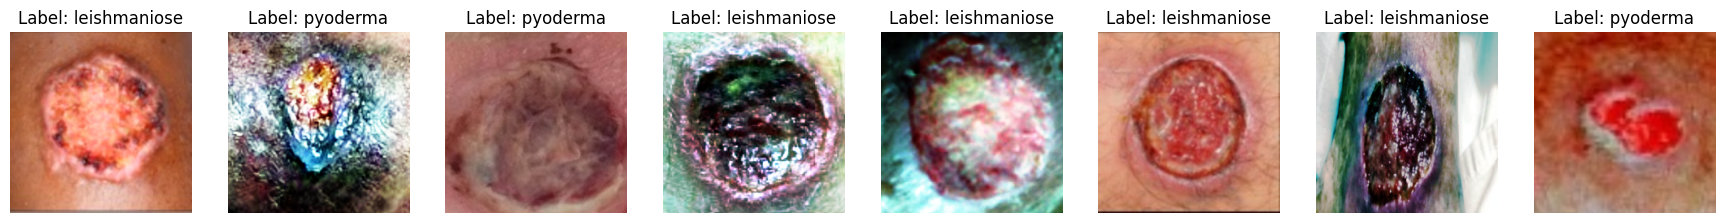

In [8]:
# Exibir as imagens com transformações
fig, axes = plt.subplots(1, len(images), figsize=(22, 10))
for i, img in enumerate(images):
    label_value = labels[i].item()
    print(f'Imagem {i}, Label: {label_value}')  # Mostra o valor do rótulo
    ax = axes[i]
    ax.set_title(f"Label: {'leishmaniose' if label_value == 0 else 'pyoderma'}")
    ax.axis('off')
    plt.sca(ax)
    imshow(img)

plt.show()

In [9]:
train_loader.dataset.classes

['leishmaniose', 'pyoderma']

In [10]:
test_loader.dataset.classes

['leishmaniose', 'pyoderma']

In [11]:
print('length of train dataset: {}'.format(len(train_loader.dataset.samples)))

length of train dataset: 51


In [12]:
print('length of test dataset: {}'.format(len(test_loader.dataset.samples)))

length of test dataset: 16


In [13]:
# Mapeamento de classes para índices
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

{'leishmaniose': 0, 'pyoderma': 1}


In [14]:
# Mapeamento de classes para índices
class_to_idx = test_dataset.class_to_idx
print(class_to_idx)

{'leishmaniose': 0, 'pyoderma': 1}


## Model Train

In [15]:
# Carregar o modelo AlexNet pré-treinado
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

In [16]:
# Congelar os parâmetros do modelo para evitar treinar toda a rede
for param in model.parameters():
    param.requires_grad = False

In [17]:
# Modificar a última camada para se ajustar ao número de classes do seu dataset
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [18]:
num_classes

2

In [19]:
# Definir o otimizador e a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [20]:
# Treinamento do modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 0.9601
Epoch [2/10], Loss: 1.2507
Epoch [3/10], Loss: 0.4895
Epoch [4/10], Loss: 0.4654
Epoch [5/10], Loss: 0.2833
Epoch [6/10], Loss: 0.3839
Epoch [7/10], Loss: 0.2927
Epoch [8/10], Loss: 0.2278
Epoch [9/10], Loss: 0.2398
Epoch [10/10], Loss: 0.1410


## Model Evatualion

In [22]:
# Avaliação do modelo
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # Armazene os rótulos e as previsões
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [23]:
print(f'Acurácia no conjunto de teste: {100 * correct / total:.2f}%')

Acurácia no conjunto de teste: 75.00%


In [24]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



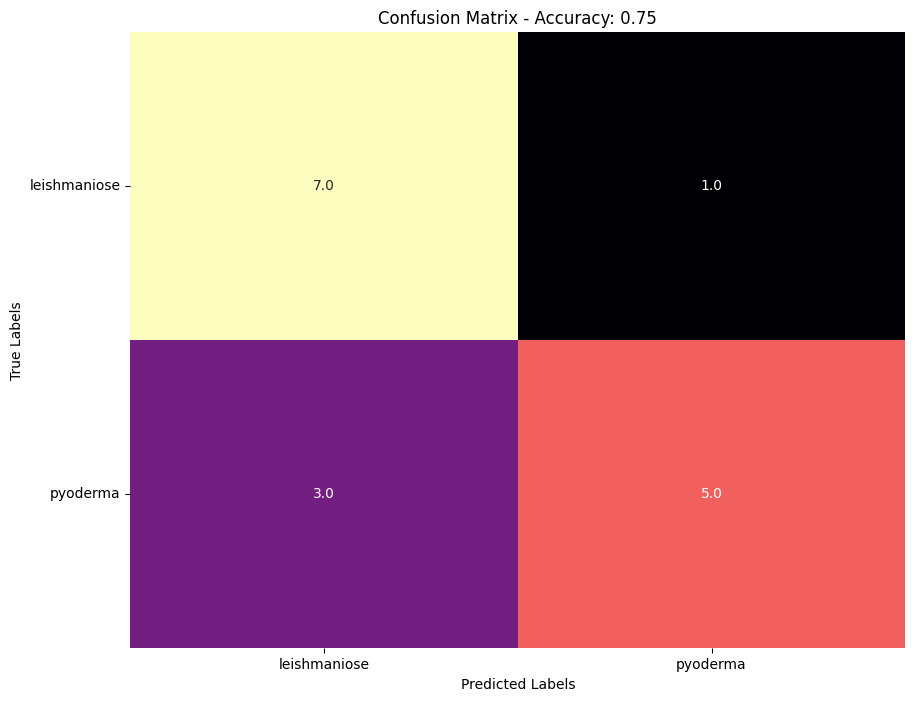

In [25]:
# Criar a matriz de confusão
cm = confusion_matrix(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

# Plotar a matriz de confusão com Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='.1f', cmap='magma', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.2f}')
ax.set_xticklabels(['leishmaniose', 'pyoderma',])
ax.set_yticklabels(['leishmaniose', 'pyoderma'], rotation=0)
plt.show()

## Model Deployment